<a href="https://colab.research.google.com/github/Soniartha/Trading-Strategy/blob/main/SARIMA_TESLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings                                     # do not disturbed mode
warnings.filterwarnings('ignore')

In [1]:
# load the packages
import numpy as np                  # vector and matrics
import pandas as pd                 # tabel and data manipulates
import matplotlib.pyplot as plt     # plots
import seaborn as sns               # more plots

from dateutil.relativedelta import relativedelta      # working with date with style  
from scipy.optimize import minimize                   # for function minimzation

import statsmodels.formula.api as smf   # stats and economy metrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product   # some useful function
from tqdm import tqdm_notebook

#importing everything for forecasting quality metrics
from sklearn.metrics import r2_score,median_absolute_error,mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#data reader
import pandas_datareader as web

#datetime
import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def mean_absolute_persentage_error (y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred)/ y_true)) * 100

def tsplot (y, lags=None, figsize = (12,7), style = 'bmh'):
  """
      plot time series, it ACF and PACF, calculate Dickey-Fuller test

      y - time series
      lags - how many lags to include in AFC, PAFC calculation
  """
  if not isinstance(y, pd.Series):
    y = pd.Series(y)

  with plt.style.context(style):
    fig = plt.figure(figsize = figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan= 2)
    afc_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    y.plot(ax = ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Plots\n Dicky-Fuller: p={0:.5f}'.format (p_value))
    smt.graphics.plot_acf(y, lags = lags, ax = afc_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax = pacf_ax)
    plt.tight_layout()

In [5]:
# Prepare the data
df = web.DataReader('TSLA',data_source='yahoo', start = '2020-01-01', end = '2021-03-14')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001
...,...,...,...,...,...,...
2021-03-08,620.130005,558.789978,600.549988,563.000000,51787000.0,563.000000
2021-03-09,678.090027,595.210022,608.179993,673.580017,67523300.0,673.580017
2021-03-10,717.849976,655.059998,700.299988,668.059998,60605700.0,668.059998


In [6]:
df_close = df.filter(['Close'])
df_volume = df.filter(['Volume'])
df_close, df_volume

(                 Close
 Date                  
 2020-01-02   86.052002
 2020-01-03   88.601997
 2020-01-06   90.307999
 2020-01-07   93.811996
 2020-01-08   98.428001
 ...                ...
 2021-03-08  563.000000
 2021-03-09  673.580017
 2021-03-10  668.059998
 2021-03-11  699.599976
 2021-03-12  693.729980
 
 [301 rows x 1 columns],                  Volume
 Date                   
 2020-01-02   47660500.0
 2020-01-03   88892500.0
 2020-01-06   50665000.0
 2020-01-07   89410500.0
 2020-01-08  155721500.0
 ...                 ...
 2021-03-08   51787000.0
 2021-03-09   67523300.0
 2021-03-10   60605700.0
 2021-03-11   36253900.0
 2021-03-12   33583800.0
 
 [301 rows x 1 columns])

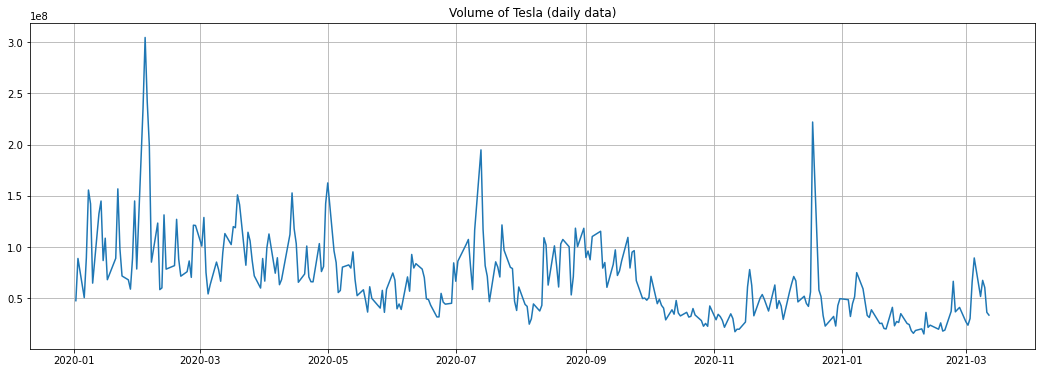

In [7]:
# Plot time series data
# ACF and PACF function will be very useful for estimate the ARMA parameters, keep in mid
plt.figure(figsize=(18,6))
plt.plot(df_volume.Volume)
plt.title('Volume of Tesla (daily data)')
plt.grid(True)
plt.show()

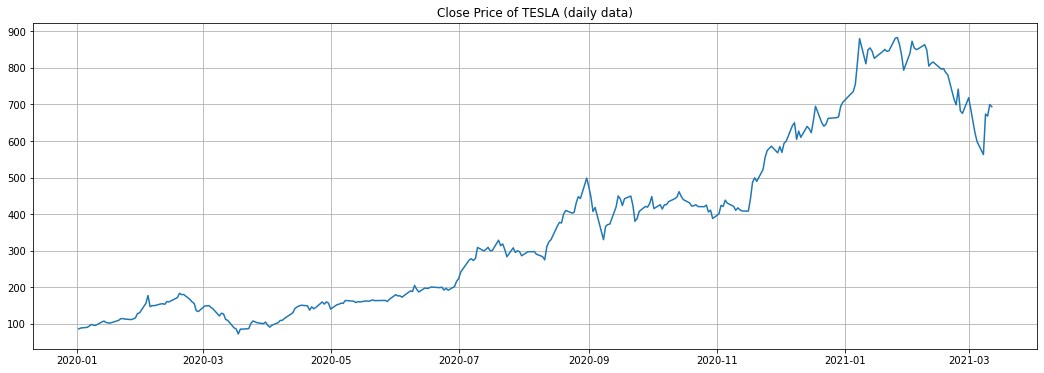

In [8]:
plt.figure(figsize=(18,6))
plt.plot(df_close.Close)
plt.title('Close Price of TESLA (daily data)')
plt.grid(True)
plt.show()

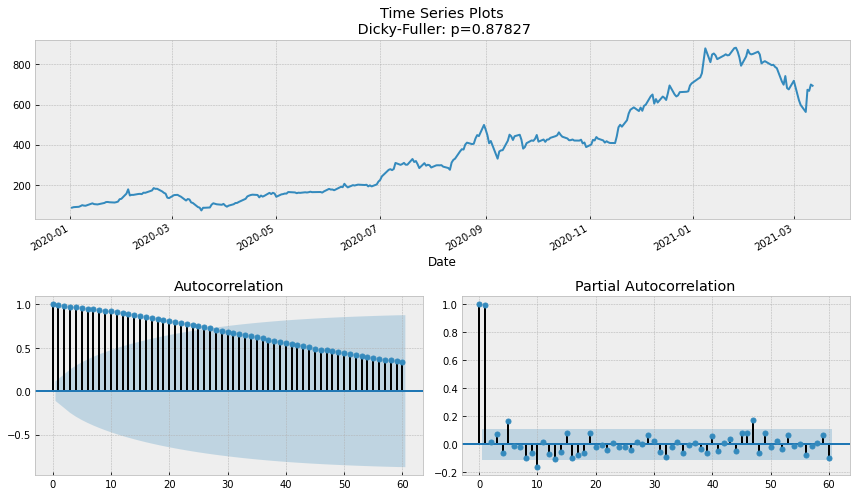

In [9]:
tsplot(df_close.Close, lags = 60)

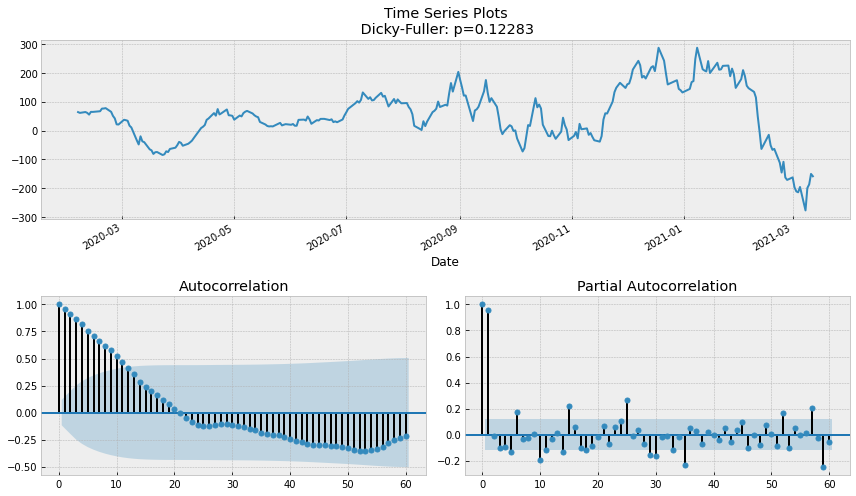

In [10]:
#The seasonal difference
close_diff = df_close.Close - df_close.Close.shift(24)
tsplot(close_diff[24:], lags = 60) 

#SARIMA PARAMETER

1.   p is most probably 4 since it is the last significant lag on the **PACF** , after which most other are not significabt

2.   d equals 1 because we had first difference
3.   q shuld be somewhere around 4 as well as seen on the ACF
4.   P might be 2m seince 24-TH and 48-th lags are somewhat significant on the PACF
5. D again equals 1 because we performed seasonal differentiation
6.  Q is probably 1. The 14 th lag on ACF is significant whilse the 48-th in not





In [11]:
# setting initial value and some bounds for them
ps = range(2,5)
d = 1
qs = range (2,5)
Ps = range (0,2)
D = 1
Qs = range (0,2)
s = 24 #season length in still 24

# Creating list wiht all possible combination fo parameters
parameters = product (ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [12]:
def optimizeSARIMA (y, parameters_list, d, D, s):
  """ Return dataframe with parameter and corresponding AIC
  y - timeseries
  parameter_list - list with (p, q, P, Q) tuples
  d - integration order in ARIMA model
  D - seasonal integraion order
  s - length of season
  """

  result = []
  best_aic = float('inf')

  for param in  tqdm_notebook(parameters_list):
    #we need try-expect because on some combination models fail to converbe 
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), seasonal_order = (param[2], D, param[3],s )).fit(disp=-1)
    except:
      continue
    aic = model.aic
    #saving best model, AIC and parametes
    if aic < best_aic:
      best_model = model
      best_aic = aic
      best_param = param
    result.append([param, model.aic])
  
  result_table = pd.DataFrame(result)
  result_table.columns = ['parameter', 'aic']
  #sorting in ascending order, the lower aic is - the better
  result_table = result_table.sort_values(by = 'aic', ascending = True). reset_index(drop = True)

  return result_table

In [13]:
%%time
warnings.filterwarnings('ignore')
result_table = optimizeSARIMA(df_close.Close, parameters_list, d, D, s)


CPU times: user 15min 22s, sys: 10min 59s, total: 26min 21s
Wall time: 13min 22s


In [14]:
result_table.head()

,parameter,aic
0,"(2, 2, 0, 1)",2482.306740
1,"(2, 3, 0, 1)",2484.480560
2,"(3, 2, 0, 1)",2486.140108
3,"(3, 2, 1, 1)",2486.331929
4,"(4, 3, 0, 1)",2488.067081


In [15]:
#set the parameter thatt give the lowest AIC
p, q, P, Q = result_table.parameter[0]

best_model = sm.tsa.statespace.SARIMAX(df_close.Close, order=(p,d,q), seasonal_order= (P, D, Q, s)). fit(display=-1) 

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                  301
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -1235.153
Date:                            Fri, 19 Mar 2021   AIC                           2482.307
Time:                                    13:21:16   BIC                           2504.029
Sample:                                         0   HQIC                          2491.024
                                            - 301                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1622      0.022      7.305      0.000       0.119       0.206
ar.L2         -0.9664      0.020   

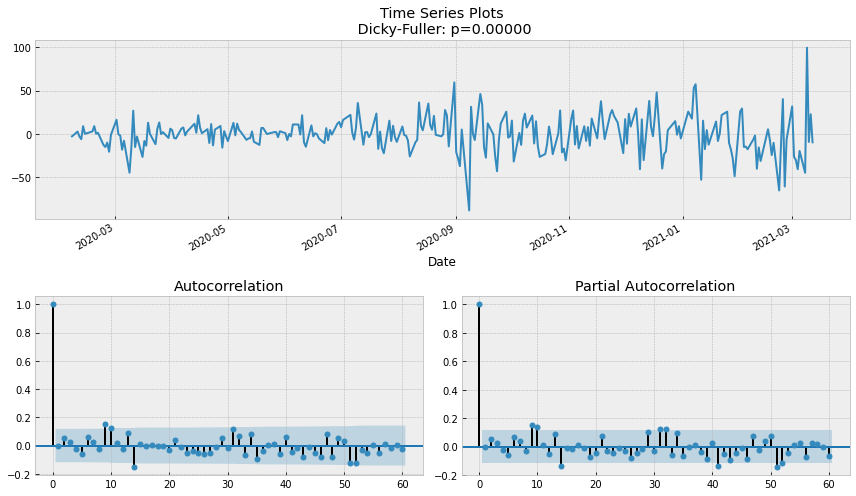

In [16]:
tsplot(best_model.resid[24+1:], lags = 60)

In [19]:
def plotSARIMA (series, model, n_steps):
  """ Plots model vs predicted values

      series - dataset with timeseries
      model - fitted SARIMA model
      n_steps - number of steps to predict int the future
  """

  #adding model values
  data = series.copy()
  data.columns = ['actual']
  data['sarima_model'] = model.fittedvalues
  #making a shift on s+d steps, because these values were unobserved by the model
  #due to the differentiating
  data['sarima_model'][:s+d] = np.NaN

  #forecasting on n_steps forward
  forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
  future_forecast = model.forecast(n_steps)[0]
  future_forecast = data.sarima_model.append(forecast)
  
  #calculate error, again having shifted on s+d steps from the begining
  #error = mean_absolute_persentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

  plt.figure(figsize=(15,7))
  plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
  plt.plot(forecast, color = 'r', label = 'model')
  plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
  plt.plot(data.actual, label = 'actual')
  plt.legend()
  plt.grid(True)

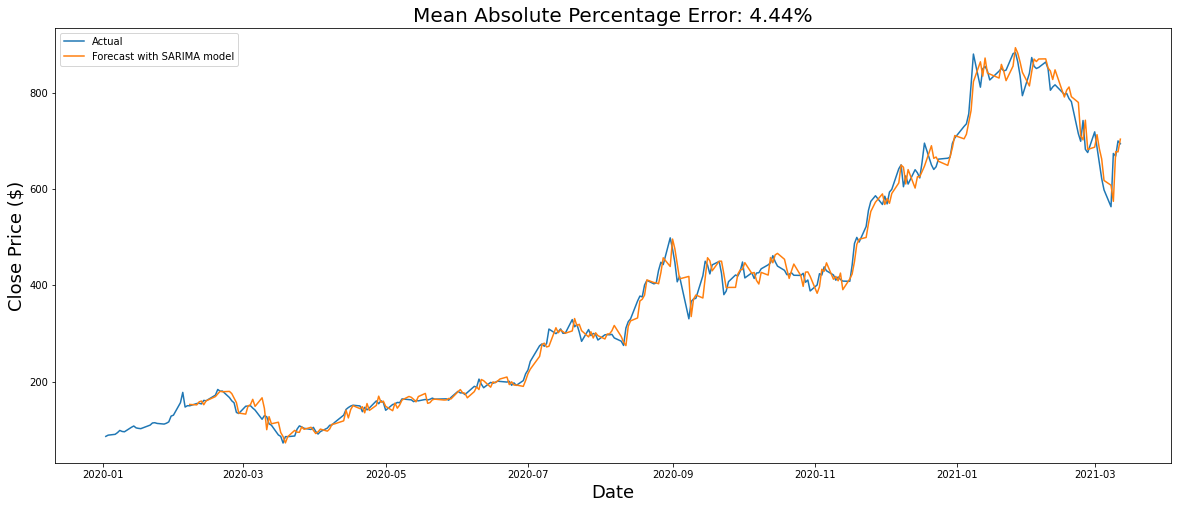

In [37]:
#adding model values
dap = df_close.copy()
dap.columns = ['actual']
dap['sarima_model'] = best_model.fittedvalues
error = mean_absolute_persentage_error(dap['actual'][s+d:], dap['sarima_model'][s+d:])
#making a shift on s+d steps, because these values were unobserved by the model
#due to the differentiating
dap['sarima_model'][:s+d] = np.NaN
plt.figure(figsize=(20,8))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize = 20)
plt.plot(dap.actual, label = 'Actual')
plt.plot(dap.sarima_model, label = 'Forecast with SARIMA model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.legend()
plt.show()


In [ ]:
tesla_future = web.DataReader('TSLA', data_source= 'yahoo', start = '2021-03-13', end = '2021-03-19')
tesla_future = tesla_future.filter(['Close'])

fore_tesla = tesla_future.copy()
fore_tesla.columns = ['actual']
fore_tesla['sarima_model'] = best_model.fittedvalues
fore_tesla

#error1 = mean_absolute_persentage_error(fore_tesla['actual'][s+d:], fore_tesla['sarima_model'][s+d:])

#dap['sarima_model'][:s+d] = np.NaN


In [30]:
pred = best_model.get_forecast(steps=20)
pred_ci = pred.conf_int()

ax = df_close.plot(label='observed', figsize = (20,5))
pred.predicted_mean.plot(ax=ax, label='forecast')

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd17853b950> (for post_execute):


ValueError: ignored

ValueError: ignored

In [ ]:
plotSARIMA(df_close, best_model, 10)